### Full conversion of TF model to CoreML

This notebook provides a good example of how to work with tf -> coreml conversion aтв also how to test model after this conversion.

In [1]:
import tensorflow as tf
print("TF version:", tf.__version__)

import numpy as np
from matplotlib import pyplot as plt
import network
slim = tf.contrib.slim

import os
import argparse
import json

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TF version: 1.12.0


#### Load model from checkpoint

In [2]:
with open('train/data.json', 'r') as fp:
    args = json.load(fp)

class Dotdict(dict):
     """dot.notation access to dictionary attributes"""
     __getattr__ = dict.get
     __setattr__ = dict.__setitem__
     __delattr__ = dict.__delitem__

args = Dotdict(args)

# 0=background
# 1=aeroplane
# 2=bicycle
# 3=bird
# 4=boat
# 5=bottle
# 6=bus
# 7=car
# 8=cat
# 9=chair
# 10=cow
# 11=diningtable
# 12=dog
# 13=horse
# 14=motorbike
# 15=person
# 16=potted plant
# 17=sheep
# 18=sofa
# 19=train
# 20=tv/monitor
# 255=unknown

class_labels = [v for v in range((args.number_of_classes+1))]
class_labels[-1] = 255

In [3]:
args

{'accumulated_validation_miou': 0,
 'batch_norm_decay': 0.997,
 'batch_norm_epsilon': 1e-05,
 'batch_size': 16,
 'crop_size': 512,
 'current_best_val_loss': '0.294389428197',
 'gpu_id': 1,
 'l2_regularizer': 0.0001,
 'multi_grid': [1, 2, 4],
 'number_of_classes': 21,
 'output_stride': 16,
 'resnet_model': 'resnet_v2_50',
 'starting_learning_rate': 1e-05}

#### We want to upload image for testing and create dataset for this image. Could be usefull for the following inference.

In [4]:
# step 1
filenames = tf.constant(['test_image/4.jpg'])

# step 2: create a dataset returning slices of `filenames`
dataset = tf.data.Dataset.from_tensor_slices((filenames))

# step 3: parse every image in the dataset using `map`
def _parse_function(filename):
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.resize_images(image_decoded, size=[513, 513], 
                                   method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = tf.cast(image, tf.float32)
    return image

dataset = dataset.map(_parse_function)
dataset = dataset.batch(1)

# step 4: create iterator and final input tensor
iterator = dataset.make_one_shot_iterator()
batch_images_tf = iterator.get_next()

(1, 513, 513, 3)


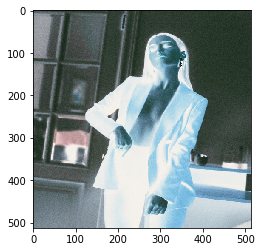

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import PIL

%matplotlib inline

try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

jpeg_bin_tensor = batch_images_tf

with tf.Session() as sess:
    # display encoded back to image data
    jpeg_bin = sess.run(jpeg_bin_tensor)
    print(jpeg_bin.shape)
    plt.imshow(jpeg_bin[0])

In [6]:
jpeg_bin.shape

(1, 513, 513, 3)

#### This function is for downloading resnet checkpoint

In [7]:
import urllib
import tarfile
import os

def download_resnet_checkpoint_if_necessary(resnet_checkpoints_path, resnet_model_name):
    """
    Check if the resnet checkpoints are already downloaded, if not download it
    :param resnet_checkpoints_path: string: path where the properly resnet checkpoint files should be found
    :param resnet_model_name: one of resnet_v2_50 or resnet_v2_101
    :return: None
    """
    if not os.path.exists(resnet_checkpoints_path):
        # create the path and download the resnet checkpoints
        os.mkdir(resnet_checkpoints_path)

        filename = resnet_model_name + "_2017_04_14.tar.gz"

        url = "http://download.tensorflow.org/models/" + filename
        full_file_path = os.path.join(resnet_checkpoints_path, filename)
        urllib.request.urlretrieve(url, full_file_path)
        thetarfile = tarfile.open(full_file_path, "r:gz")
        thetarfile.extractall(path=resnet_checkpoints_path)
        thetarfile.close()
        print("Resnet:", resnet_model_name, "successfully downloaded.")
    else:
        print("ResNet checkpoints file successfully found.")

In [8]:
download_resnet_checkpoint_if_necessary("resnet/checkpoints/", 'resnet_v2_50')

ResNet checkpoints file successfully found.


#### Here we are creating the graph for tensorflow model

In [9]:
batch_images = tf.placeholder(tf.float32, [None, 513, 513, 3])

In [10]:
logits_tf =  network.deeplab_v3(batch_images, 
                                args, 
                                is_training=False, reuse=tf.AUTO_REUSE)

predictions_tf = tf.argmax(logits_tf, axis=3)
probabilities_tf = tf.nn.softmax(logits_tf[0])

map_resized_back = tf.image.resize_images(probabilities_tf, [960, 768])

merged_summary_op = tf.summary.merge_all()
saver = tf.train.Saver()

test_folder = 'train'

#### Loading session and saving it

In [11]:
with tf.Session() as sess:

    # Create a saver.
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())

    # Restore variables from disk.
    saver.restore(sess, os.path.join(test_folder, "model.ckpt"))
    print("Model restored.")
    
    probabilities_tf_np = sess.run([probabilities_tf], 
                                   feed_dict={batch_images: jpeg_bin})
    
    tf.train.write_graph(sess.graph, './', 'model.pbtxt')

INFO:tensorflow:Restoring parameters from train/model.ckpt
Model restored.


#### Freezing session graph and saving it.

In [12]:
from tensorflow.python.tools.freeze_graph import freeze_graph

# Graph definition file, stored as protobuf TEXT
graph_def_file = './model.pbtxt'
# Trained model's checkpoint name
checkpoint_file = './train/model.ckpt'
# Frozen model's output name
frozen_model_file = './frozen_model.pb'
# Output nodes. If there're multiple output ops, use comma separated string, e.g. "out1,out2".
output_node_names = 'Softmax' 

# Call freeze graph
freeze_graph(input_graph=graph_def_file,
             input_saver="",
             input_binary=False,
             input_checkpoint=checkpoint_file,
             output_node_names=output_node_names,
             restore_op_name="save/restore_all",
             filename_tensor_name="save/Const:0",
             output_graph=frozen_model_file,
             clear_devices=True,
             initializer_nodes="")

Instructions for updating:
Use tf.gfile.GFile.
INFO:tensorflow:Restoring parameters from ./train/model.ckpt
INFO:tensorflow:Froze 298 variables.
INFO:tensorflow:Converted 298 variables to const ops.


#### Here is the convertion from tf to coreml

In [13]:
import tfcoreml

"""
Step 2: Call converter
"""

# Provide these inputs in addition to inputs in Step 1
# A dictionary of input tensors' name and shape (with batch)
input_tensor_shapes = {"Placeholder:0":[1, 513, 513, 3]} # batch size is 1
# Output CoreML model path
coreml_model_file = 'model.mlmodel'
output_tensor_names = ['Softmax:0']


# Call the converter
coreml_model = tfcoreml.convert(
    tf_model_path=frozen_model_file, 
    mlmodel_path=coreml_model_file, 
    input_name_shape_dict=input_tensor_shapes,
    output_feature_names=output_tensor_names
)


Loading the TF graph...
Graph Loaded.
Done.
Now finding ops in the TF graph that can be dropped for inference
Now starting translation to CoreML graph.
Automatic shape interpretation succeeded for input blob Placeholder:0
1/870: Analysing op name: strided_slice/stack_2 ( type:  Const )
2/870: Analysing op name: strided_slice/stack_1 ( type:  Const )
3/870: Analysing op name: strided_slice/stack ( type:  Const )
4/870: Analysing op name: DeepLab_v3/strided_slice/stack_2 ( type:  Const )
5/870: Analysing op name: DeepLab_v3/strided_slice/stack_1 ( type:  Const )
6/870: Analysing op name: DeepLab_v3/strided_slice/stack ( type:  Const )
7/870: Analysing op name: DeepLab_v3/logits/biases ( type:  Const )
8/870: Analysing op name: DeepLab_v3/logits/biases/read ( type:  Identity )
9/870: Analysing op name: DeepLab_v3/logits/weights ( type:  Const )
10/870: Analysing op name: DeepLab_v3/logits/weights/read ( type:  Identity )
11/870: Analysing op name: DeepLab_v3/ASPP_layer/conv_1x1_output/Ba

643/870: Analysing op name: resnet_v2_50/Pad ( type:  Pad )
644/870: Analysing op name: resnet_v2_50/conv1/Conv2D ( type:  Conv2D )
645/870: Analysing op name: resnet_v2_50/conv1/BiasAdd ( type:  BiasAdd )
646/870: Analysing op name: resnet_v2_50/pool1/MaxPool ( type:  MaxPool )
647/870: Analysing op name: resnet_v2_50/block1/unit_1/bottleneck_v2/preact/FusedBatchNorm ( type:  FusedBatchNorm )
648/870: Analysing op name: resnet_v2_50/block1/unit_1/bottleneck_v2/preact/Relu ( type:  Relu )
649/870: Analysing op name: resnet_v2_50/block1/unit_1/bottleneck_v2/conv1/Conv2D ( type:  Conv2D )
650/870: Analysing op name: resnet_v2_50/block1/unit_1/bottleneck_v2/conv1/BatchNorm/FusedBatchNorm ( type:  FusedBatchNorm )
651/870: Analysing op name: resnet_v2_50/block1/unit_1/bottleneck_v2/conv1/Relu ( type:  Relu )
652/870: Analysing op name: resnet_v2_50/block1/unit_1/bottleneck_v2/conv2/Conv2D ( type:  Conv2D )
653/870: Analysing op name: resnet_v2_50/block1/unit_1/bottleneck_v2/conv2/BatchNorm

726/870: Analysing op name: resnet_v2_50/block2/unit_4/bottleneck_v2/conv2/Conv2D ( type:  Conv2D )
727/870: Analysing op name: resnet_v2_50/block2/unit_4/bottleneck_v2/conv2/BatchNorm/FusedBatchNorm ( type:  FusedBatchNorm )
728/870: Analysing op name: resnet_v2_50/block2/unit_4/bottleneck_v2/conv2/Relu ( type:  Relu )
729/870: Analysing op name: resnet_v2_50/block2/unit_4/bottleneck_v2/conv3/Conv2D ( type:  Conv2D )
730/870: Analysing op name: resnet_v2_50/block2/unit_4/bottleneck_v2/conv3/BiasAdd ( type:  BiasAdd )
731/870: Analysing op name: resnet_v2_50/block2/unit_4/bottleneck_v2/add ( type:  Add )
732/870: Analysing op name: resnet_v2_50/block3/unit_1/bottleneck_v2/preact/FusedBatchNorm ( type:  FusedBatchNorm )
733/870: Analysing op name: resnet_v2_50/block3/unit_1/bottleneck_v2/preact/Relu ( type:  Relu )
734/870: Analysing op name: resnet_v2_50/block3/unit_1/bottleneck_v2/conv1/Conv2D ( type:  Conv2D )
735/870: Analysing op name: resnet_v2_50/block3/unit_1/bottleneck_v2/conv1

807/870: Analysing op name: resnet_v2_50/block4/unit_1/bottleneck_v2/conv2/BatchToSpaceND ( type:  BatchToSpaceND )
808/870: Analysing op name: resnet_v2_50/block4/unit_1/bottleneck_v2/conv2/BatchNorm/FusedBatchNorm ( type:  FusedBatchNorm )
809/870: Analysing op name: resnet_v2_50/block4/unit_1/bottleneck_v2/conv2/Relu ( type:  Relu )
810/870: Analysing op name: resnet_v2_50/block4/unit_1/bottleneck_v2/conv3/Conv2D ( type:  Conv2D )
811/870: Analysing op name: resnet_v2_50/block4/unit_1/bottleneck_v2/conv3/BiasAdd ( type:  BiasAdd )
812/870: Analysing op name: resnet_v2_50/block4/unit_1/bottleneck_v2/shortcut/Conv2D ( type:  Conv2D )
813/870: Analysing op name: resnet_v2_50/block4/unit_1/bottleneck_v2/shortcut/BiasAdd ( type:  BiasAdd )
814/870: Analysing op name: resnet_v2_50/block4/unit_1/bottleneck_v2/add ( type:  Add )
815/870: Analysing op name: resnet_v2_50/block4/unit_2/bottleneck_v2/preact/FusedBatchNorm ( type:  FusedBatchNorm )
816/870: Analysing op name: resnet_v2_50/block4

In [14]:
coreml_model

input {
  name: "Placeholder__0"
  type {
    multiArrayType {
      shape: 3
      shape: 513
      shape: 513
      dataType: DOUBLE
    }
  }
}
output {
  name: "Softmax__0"
  type {
    multiArrayType {
      dataType: DOUBLE
    }
  }
}

#### Let's test it!

In [15]:
"""
Step 3: Run the converted model
"""

# Provide CoreML model with a dictionary as input. Change ':0' to '__0'
# as Swift / Objective-C code generation do not allow colons in variable names
np.random.seed(100)
coreml_inputs = {'Placeholder__0': np.moveaxis(jpeg_bin[0], 2, 0)} # (sequence_length=1,batch=1,channels=784)
coreml_output = coreml_model.predict(coreml_inputs, useCPUOnly=True)

In [16]:
coreml_output['Softmax__0'][0][0][15]

array([[8.69663927e-06, 8.75525620e-06, 8.81426968e-06, ...,
        5.59820421e-07, 5.59820421e-07, 5.59820421e-07],
       [1.05779181e-05, 1.06630832e-05, 1.07488877e-05, ...,
        5.71514192e-07, 5.71514192e-07, 5.71514192e-07],
       [1.28661422e-05, 1.29865730e-05, 1.31081497e-05, ...,
        5.83452163e-07, 5.83452163e-07, 5.83452163e-07],
       ...,
       [2.05195183e-03, 1.71889353e-03, 1.43965404e-03, ...,
        1.20850040e-04, 1.20850040e-04, 1.20850040e-04],
       [2.05195183e-03, 1.71889353e-03, 1.43965404e-03, ...,
        1.20850040e-04, 1.20850040e-04, 1.20850040e-04],
       [2.05195183e-03, 1.71889353e-03, 1.43965404e-03, ...,
        1.20850040e-04, 1.20850040e-04, 1.20850040e-04]])

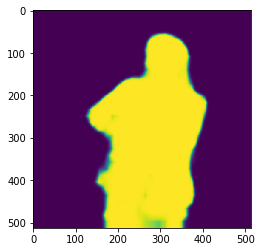

In [17]:
plt.imshow(coreml_output['Softmax__0'][0][0][15], )

In [18]:
import cv2

resized_output = cv2.resize(np.array(coreml_output['Softmax__0'][0][0][15]), dsize=(768, 960), )

#### Yeah, we get it!

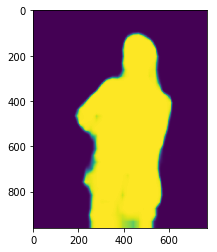

In [19]:
plt.imshow(resized_output)

In [28]:
input_img = cv2.imread('test_image//4.jpg')

In [29]:
resized_output[:, :, None][resized_output[:, :, None] > 0.5] = 1.0
resized_output[:, :, None][resized_output[:, :, None] <= 0.5] = 0.0

In [35]:
def show_images(input_image, input_title, output_image, output_title, cmap=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 35))
    
    ax1.imshow(input_image, cmap=cmap)
    ax1.set_title(input_title)
    
    ax2.imshow(output_image, cmap=cmap)
    ax2.set_title(output_title)

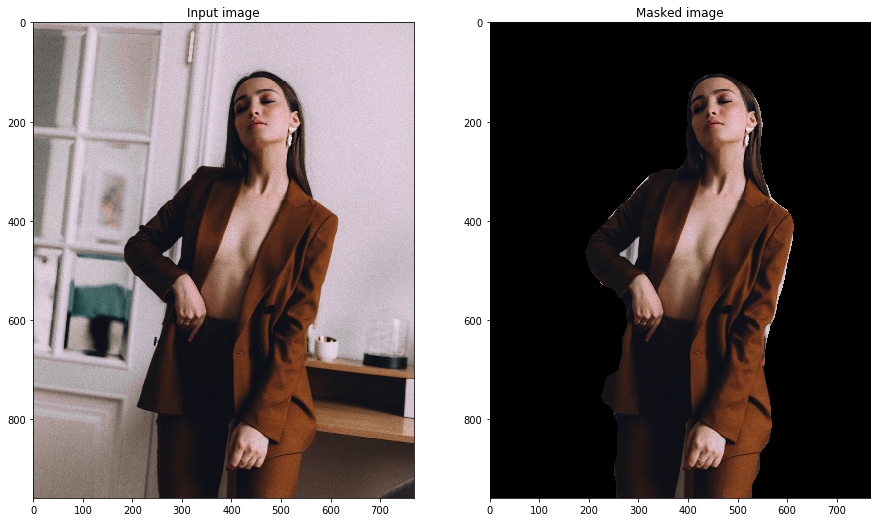

In [36]:
show_images(cv2.cvtColor(np.array(input_img, dtype=np.uint8), cv2.COLOR_BGR2RGB), "Input image", 
            cv2.cvtColor(np.array(result_mask, dtype=np.uint8), cv2.COLOR_BGR2RGB), "Masked image", cmap=None)